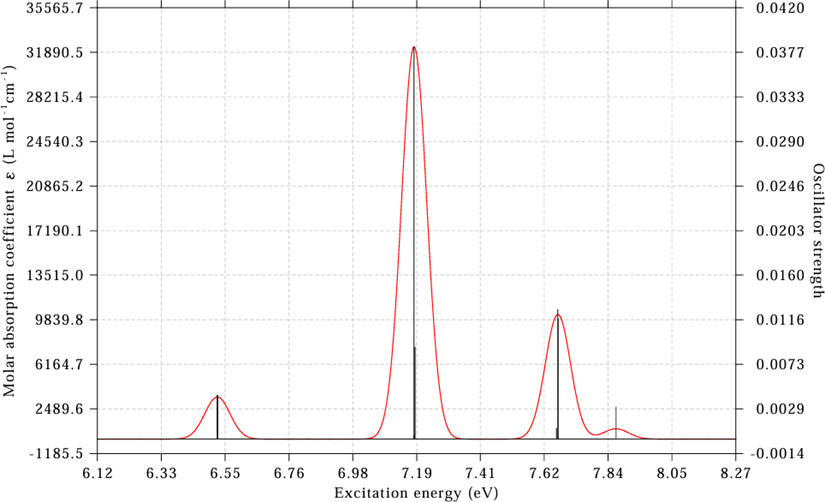

#### Above is the UV-Vis spectrum of Multiwfn (fwhm=0.1, Gaussian broden). As a benchmark, check the python code for UV-Vis spectrum.                                                            

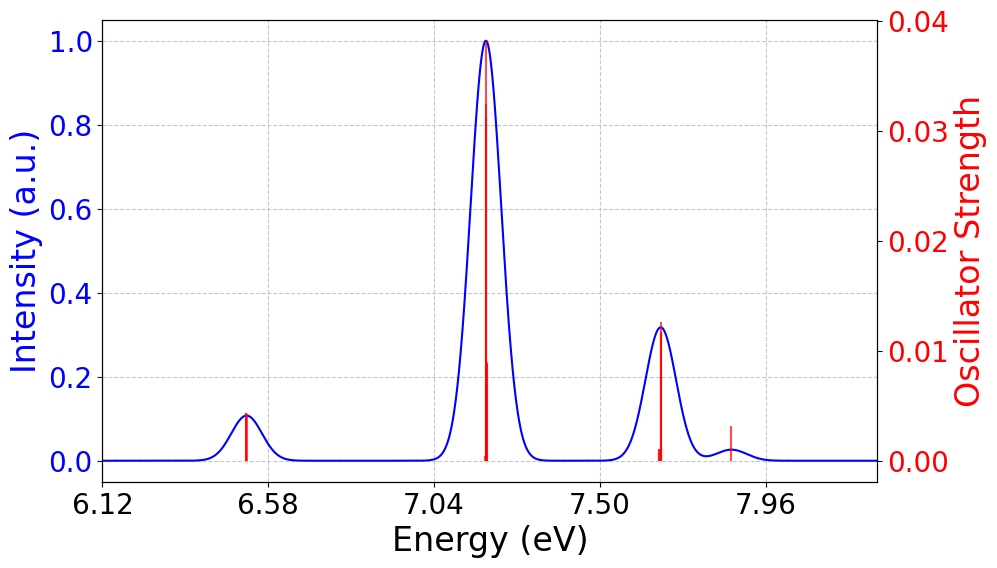

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import glob

# Function to parse spectrum data from a log file
def parse_spectrum_data_from_log(file_path):
    energy_levels = []
    intensities = []
    oscillator_strengths = []  # Store oscillator strengths
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith(' TDDFPT|') and len(line.split()) >= 7:
                parts = line.split()
                try:
                    energy = float(parts[2])  # Excitation energy (eV)
                    intensity = float(parts[-1])  # Oscillator strength
                    energy_levels.append(energy)
                    intensities.append(intensity)
                    oscillator_strengths.append(intensity)  # Assuming intensity represents oscillator strength
                except ValueError:
                    continue

    return np.array(energy_levels), np.array(intensities), np.array(oscillator_strengths)

# Function to calculate spectrum with Gaussian broadening
def gaussian_broadening(energy_levels, intensities, fwhm, num_points=5000, x_shift=0):
    energy_levels += x_shift  # Apply x-axis shift
    x_min = np.min(energy_levels) - 5 * fwhm
    x_max = np.max(energy_levels) + 5 * fwhm
    x = np.linspace(x_min, x_max, num_points)
    
    y = np.zeros_like(x)
    for energy, intensity in zip(energy_levels, intensities):
        y += intensity * np.exp(-((x - energy) ** 2) / (2 * (fwhm / 2.35482) ** 2))

    # Normalize the spectrum
    y /= np.max(y)
    return x, y

# Function to plot the spectrum with additional y-axis for oscillator strength
def plot_spectrum(energy_levels, intensities, oscillator_strengths=None, fwhm=0.1, x_shift=0, show_oscillator_strengths=False, save_path=None):
    # Apply x-axis shift to energy levels
    shifted_energy_levels = energy_levels + x_shift

    # Generate Gaussian broadened spectrum
    x, y = gaussian_broadening(energy_levels, intensities, fwhm, x_shift=x_shift)
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Plot normalized spectrum on the left y-axis
    ax1.plot(x, y, label='UV-Vis Spectrum', color='blue')
    ax1.set_xlabel('Energy (eV)', fontsize=24)
    ax1.set_ylabel('Intensity (a.u.)', fontsize=24, color='blue')
    ax1.tick_params(axis='y', labelsize=20, colors='blue')
    ax1.tick_params(axis='x', labelsize=20)
    ax1.set_xlim(6.12 + x_shift, 8.27 + x_shift)  # Adjust x-axis limits based on shift
    x_ticks = np.arange(6.12 + x_shift, 8.28 + x_shift, 0.46)  # Adjust ticks based on shift
    ax1.set_xticks(x_ticks)
    ax1.grid(True, linestyle='--', alpha=0.7)

    # Optionally add the right y-axis for oscillator strengths
    if show_oscillator_strengths and oscillator_strengths is not None:
        ax2 = ax1.twinx()
        ax2.set_ylabel("Oscillator Strength", color="red", fontsize=24)
        for energy, strength in zip(shifted_energy_levels, oscillator_strengths):  # Apply shift to oscillator strength positions
            ax2.vlines(x=energy, ymin=0, ymax=strength, color="red", alpha=0.7)
        ax2.tick_params(axis='y', labelcolor="red", labelsize=20)

    # Save plot if save_path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Function to read and plot spectra from multiple log files
def process_and_plot_all_logs(log_file_pattern, fwhm=0.1, x_shift=0, show_oscillator_strengths=False, save_path=None):
    all_energy_levels = []
    all_intensities = []
    all_oscillator_strengths = []

    log_files = glob.glob(log_file_pattern)
    if not log_files:
        print(f"No log files found matching the pattern: {log_file_pattern}")
        return

    for log_file in log_files:
        energy_levels, intensities, oscillator_strengths = parse_spectrum_data_from_log(log_file)
        all_energy_levels.extend(energy_levels)
        all_intensities.extend(intensities)
        all_oscillator_strengths.extend(oscillator_strengths)

    all_energy_levels = np.array(all_energy_levels)
    all_intensities = np.array(all_intensities)
    all_oscillator_strengths = np.array(all_oscillator_strengths)

    plot_spectrum(all_energy_levels, all_intensities, all_oscillator_strengths, fwhm, x_shift, show_oscillator_strengths, save_path)

# Example usage:
log_file_pattern = "step_opt.log"  # Adjust pattern to match your needs
process_and_plot_all_logs(log_file_pattern, fwhm=0.1, x_shift=0, show_oscillator_strengths=True, save_path='test.png')  # Add x_shift and control oscillator strength display



#### The python code successfully copies Multiwfn's Fortran code and continues to batch process CP2K step2's all_logfiles.

In [3]:
import os

# Function to parse spectrum data from a log file
def parse_spectrum_data_from_log(file_path):
    energy_levels, intensities = [], []
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith(' TDDFPT|') and len(line.split()) >= 7:
                parts = line.split()
                try:
                    energy_levels.append(float(parts[2]))  # Excitation energy (eV)
                    intensities.append(float(parts[-1]))  # Oscillator strength
                except ValueError:
                    continue
    return np.array(energy_levels), np.array(intensities)

# Function to calculate spectrum with Gaussian broadening
def gaussian_broadening(energy_levels, intensities, fwhm, num_points=1000):
    if len(energy_levels) == 0 or len(intensities) == 0:
        raise ValueError("Energy levels or intensities array is empty. Check input data.")
    x = np.linspace(np.min(energy_levels) - 5 * fwhm, np.max(energy_levels) + 5 * fwhm, num_points)
    y = np.sum([intensity * np.exp(-((x - energy) ** 2) / (2 * (fwhm / 2.35482) ** 2)) for energy, intensity in zip(energy_levels, intensities)], axis=0)
    return x, y

# Function to generate and save spectrum for each log file
def generate_and_save_spectra(log_file_pattern, output_folder, fwhm=0.1, num_points=1000):
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    log_files = glob.glob(log_file_pattern)
    if not log_files:
        raise FileNotFoundError(f"No files matched the pattern: {log_file_pattern}")

    for log_file in log_files:
        print(f"Processing: {log_file}")
        energy_levels, intensities = parse_spectrum_data_from_log(log_file)

        # Generate Gaussian broadened spectrum
        x, y = gaussian_broadening(energy_levels, intensities, fwhm, num_points)

        # Create output file path
        base_name = os.path.basename(log_file).replace('.log', '_spectrum.txt')
        output_file_path = os.path.join(output_folder, base_name)

        # Save spectrum data
        np.savetxt(output_file_path, np.column_stack((x, y)), header="Energy (eV)\tIntensity (a.u.)")
        print(f"Spectrum data saved to: {output_file_path}")

# Example usage:
log_file_pattern = "all_logfiles/step_*.log"
output_folder = "spectra_output"
generate_and_save_spectra(log_file_pattern, output_folder, fwhm=0.1, num_points=1000)

Processing: all_logfiles\step_251.log
Spectrum data saved to: spectra_output\step_251_spectrum.txt
Processing: all_logfiles\step_252.log
Spectrum data saved to: spectra_output\step_252_spectrum.txt
Processing: all_logfiles\step_253.log
Spectrum data saved to: spectra_output\step_253_spectrum.txt
Processing: all_logfiles\step_254.log
Spectrum data saved to: spectra_output\step_254_spectrum.txt
Processing: all_logfiles\step_255.log
Spectrum data saved to: spectra_output\step_255_spectrum.txt
Processing: all_logfiles\step_256.log
Spectrum data saved to: spectra_output\step_256_spectrum.txt
Processing: all_logfiles\step_257.log
Spectrum data saved to: spectra_output\step_257_spectrum.txt
Processing: all_logfiles\step_258.log
Spectrum data saved to: spectra_output\step_258_spectrum.txt
Processing: all_logfiles\step_259.log
Spectrum data saved to: spectra_output\step_259_spectrum.txt
Processing: all_logfiles\step_260.log
Spectrum data saved to: spectra_output\step_260_spectrum.txt
Processing

file： ['step_251_spectrum.txt', 'step_252_spectrum.txt', 'step_253_spectrum.txt', 'step_254_spectrum.txt', 'step_255_spectrum.txt', 'step_256_spectrum.txt', 'step_257_spectrum.txt', 'step_258_spectrum.txt', 'step_259_spectrum.txt', 'step_260_spectrum.txt', 'step_261_spectrum.txt', 'step_262_spectrum.txt', 'step_263_spectrum.txt', 'step_264_spectrum.txt', 'step_265_spectrum.txt', 'step_266_spectrum.txt', 'step_267_spectrum.txt', 'step_268_spectrum.txt', 'step_269_spectrum.txt', 'step_270_spectrum.txt', 'step_271_spectrum.txt', 'step_272_spectrum.txt', 'step_273_spectrum.txt', 'step_274_spectrum.txt', 'step_275_spectrum.txt']
Documents being processed: spectra_output\step_251_spectrum.txt
Documents being processed: spectra_output\step_252_spectrum.txt
Documents being processed: spectra_output\step_253_spectrum.txt
Documents being processed: spectra_output\step_254_spectrum.txt
Documents being processed: spectra_output\step_255_spectrum.txt
Documents being processed: spectra_output\step_2

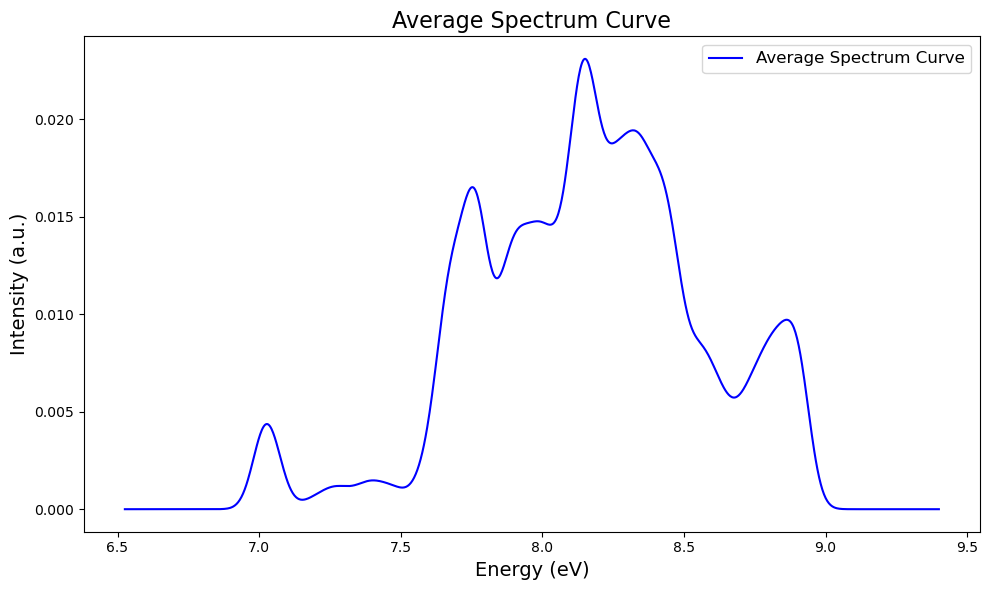

In [4]:
#Data Catalog
data_dir = "spectra_output"  
file_pattern = "step_*_spectrum.txt"


if not os.path.exists(data_dir):
    print(f" Catalog {data_dir} not exist，please check path!")
    exit()

file_list = [f for f in os.listdir(data_dir) if f.startswith("step_") and f.endswith("_spectrum.txt")]

print("file：", file_list)

# Check if the file list is empty
if not file_list:
    print(f"No matching file was found, please check the file name or path!")
    exit()

file_list = [os.path.join(data_dir, f) for f in file_list]

x_values_list = []  
y_values_list = [] 

for file_name in file_list:
    try:
        print(f"Documents being processed: {file_name}")
        data = np.loadtxt(file_name)
        x_values_list.append(data[:, 0])
        y_values_list.append(data[:, 1])
    except FileNotFoundError:
        print(f"{file_name} File not found")
    except ValueError:
        print(f"{file_name} Incorrectly formatted document content")

if x_values_list and y_values_list:
    x_values_avg = np.mean(x_values_list, axis=0)
    y_values_avg = np.mean(y_values_list, axis=0)

    average_data = np.column_stack((x_values_avg, y_values_avg))
    np.savetxt('average_spectrum_data.txt', average_data, fmt='%.6f', header='X_avg Y_avg', comments='')

    plt.figure(figsize=(10, 6))
    plt.plot(x_values_avg, y_values_avg, label='Average Spectrum Curve', color='blue')
    plt.xlabel('Energy (eV)', fontsize=14)
    plt.ylabel('Intensity (a.u.)', fontsize=14)
    plt.title('Average Spectrum Curve', fontsize=16)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.savefig('average_spectrum.png', dpi=300)

    plt.show()
else:
    print("No valid data file found")
